<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1] Setting up Environment and Install Requirements

## 1.1 Set Working Directory, Install Requirements

In [29]:
import os
import sys
# Set Path
from google.colab import drive
drive.mount('/content/drive')
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bi

## 1.2 Load and Initialize the Movie Registration Class

In [30]:
!#Load Libraries
import gc
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import re
from sources.ChinaFilm.Record_Registration import Registration # assume relative path at path_wd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
dy_reg = Registration(driver)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: use options instead of chrome_options
  from ipykernel import kernelapp as app


## 1.3 Load Latest Registration Publication

In [31]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
##########################################
# Use update_first=True to get latest records from China Film's Website
df = dy_reg.Refined_Records(update_first =False)
##########################################
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name,].reset_index(drop=True)
df_curr.columns
df_curr.head(2)

,电影类别,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数
0,故事影片,影剧备字〔2021〕第1547号,你变了，我们离婚吧,安徽艾欧联美影业有限公司,赵庆莹,同意拍摄,安徽省,一对相爱多年的80后夫妻因妻子罹患癌症，心疼丈夫的妻子智贤为爱出发致使婚姻走到尽头。在离婚冷...,2021-06-04,国家电影局关于2021年4月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 4, 整月, 4, 整月)",故事片,2021,1547,"DatetimeIndex(['2021-04-01', '2021-04-02', '20...",30
1,故事影片,影剧备字〔2021〕第1550号,摇滚乡村,安徽黑马创艺影业有限公司,李新杰,同意拍摄,安徽省,大学生村干部小余来到了菊花村开始了第六年的任期，在村书记和主任的支持下，举办了首届菊花旅游节...,2021-06-04,国家电影局关于2021年4月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 4, 整月, 4, 整月)",故事片,2021,1550,"DatetimeIndex(['2021-04-01', '2021-04-02', '20...",30


## 1.4 Load Title Prediction Model (REQUIRED GPU)

In [32]:
"""
# Prediction Model using Title Prediction BERT-based model
os.chdir('/content/drive/MyDrive/Github/Content/tools/articles')
!pip install -r /content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/requirements.txt
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import json
from tensorflow import keras
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder

dict_path ='/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/vocab.txt'
config_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_model.ckpt'
maxlen = 256
topk = 1

token_dict, keep_tokens = load_vocab(
dict_path=dict_path,
simplified=True,
startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

# Initialize model and load weights
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # include only tokens in keep tokens
)
path_weights = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/weights/StarChaser_best_model.weights'
model.load_weights(path_weights)


class AutoTitle(AutoRegressiveDecoder):
    @AutoRegressiveDecoder.wraps(default_rtype='probas')

    def predict(self, inputs, output_ids, states):
        token_ids, segment_ids = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        #####################
        return model.predict([token_ids, segment_ids])[:, -1]
        #####################

    def generate(self, text, topk=1):
        max_c_len = 256 - self.maxlen
        token_ids, segment_ids = tokenizer.encode(text, maxlen=max_c_len)
        output_ids = self.beam_search([token_ids, segment_ids],
                                      topk=topk)  # beam search
        return tokenizer.decode(output_ids)

autotitle = AutoTitle(start_id=None, end_id=tokenizer._token_end_id, maxlen=32)
"""

"\n# Prediction Model using Title Prediction BERT-based model\nos.chdir('/content/drive/MyDrive/Github/Content/tools/articles')\n!pip install -r /content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/requirements.txt\n%tensorflow_version 1.x\n\nimport numpy as np\nimport pandas as pd\nimport json\nfrom tensorflow import keras\nfrom bert4keras.models import build_transformer_model\nfrom bert4keras.tokenizers import Tokenizer, load_vocab\nfrom bert4keras.snippets import DataGenerator, AutoRegressiveDecoder\n\ndict_path ='/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/vocab.txt'\nconfig_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_config.json'\ncheckpoint_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_model.ckpt'\nmaxlen = 256\ntopk = 1\n\ntoken_dict, keep_tokens = load_vocab(\ndict_path=dict_

# [2] Generating Article Contents

##[2.1] XXXX年XX月电影备案公示划重点

In [33]:
issue_name = df_curr.loc[0,'公示批次起始'][0] + '年' + df_curr.loc[0,'公示批次起始'][1] +'月'
issue_name += df_curr.loc[0,'公示批次起始'][2]

# Title
T1 = '{year}年'.format(year=df_curr.loc[0,'公示批次起始'][0])
T1 += '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  T1 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
T1 += '电影备案公示划重点'
print(T1)

2021年4月电影备案公示划重点


##[2.2] 	XXXX年XX月XX日,XX月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号,最近期的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


In [34]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.loc[0,'公示日期'].year
pub_month = df_curr.loc[0,'公示日期'].month
pub_day = df_curr.loc[0,'公示日期'].day
df_curr['备案申请年份'] = df_curr['备案申请年份'].astype('int')
df_curr_sorted = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'], ascending=True).reset_index(drop=True)
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(ascending=False).rename('数量').to_frame().reset_index()

# Write Content
T2 = '\t'
T2 += '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
T2 += '{month}月{part_of_month}的备案公示新鲜出炉！'.format(month=df_curr.loc[0,'公示批次起始'][1], part_of_month=df_curr.loc[0,'公示批次起始'][2])
T2 += '这一批次中，最遥远的项目是《{}》，'.format(df_curr_sorted.loc[0, '片名']) 
T2 += '备案号为{}，'.format(df_curr_sorted.loc[0, '备案立项号'])
T2 += '最近期的项目是《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
T2 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
T2 += '本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    T2 = T2.rstrip('、')
    T2 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    T2 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(T2)

	2021年6月4日，4月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《英雄若兰》，备案号为影重备字〔2019〕第009号，最近期的项目是《波涛汹涌》，备案号为影剧备字〔2021〕第1723号。本次完成备案的共计故事影片257部、纪录影片14部、动画影片10部、科教影片5部、特种影片1部以及合拍影片1部。


##[2.3] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [46]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
df_focus.head(20)
ids = [12,13,67,131,158,159, 225, 257, 264, 287]
df_focus_narrowed = df_curr.loc[ids, ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
ls_ptitles =  ['单身男女的表率', '窗外有棵树', '爱在黎明前', '烽火入朝', '追击', '青春的希望', '寻找', '差生', '大圣降魔记', '东京，我们的生活']
#print(ls_ptitles)
########
T3 = '\t'
T3 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T3 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T3 += '结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了青春爱情、伦理剧情、战争和神话。\n'


for _, row in df_focus_narrowed.iterrows():
  T3 += '\n《{name}》\n编剧：{writer}'.format(name=row['片名'],writer=row['编剧'])
  T3 += '\n备案单位：{co}'.format(co=row['备案单位'])
  T3 += '\n{synopsis}\n'.format(synopsis=row['梗概'])

print(T3)

	本批次中，大数据分析识别出13部上市影视公司关联项目，占比4.51%。结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了青春爱情、伦理剧情、战争和神话。

《约会清单》
编剧：徐聪容
备案单位：北京光线传媒股份有限公司
30岁依旧单身的阮清辉陷入结婚焦虑，她受闺蜜启发，将身边的单身男性按照身高、学历、工作等条件列成表格，逐一约会，闹出不少笑话，想要放弃时意外遇到多情的沈晏和温柔的陆星沉后，阮清辉陷入了两难的抉择

《谢谢你来爱我》
编剧：林楷淳
备案单位：北京光线影业有限公司
高中时期，罗宇失手打碎教学楼的玻璃，当时刚好站在窗下的女同学董娜被砸伤，成了植物人，罗宇也因此家破人亡。多年后罗宇重遇董娜并照顾她直至清醒过来。罗宇决定用此生陪伴瘫痪的董娜并隐瞒真相，为她编织一个梦

《爱不远去》
编剧：胡绍祥
备案单位：京唐儒意（厦门）影业有限公司
讲述了女画家霍雅兰.舞蹈演员周雪莲和摄影师高天启的爱情故事，高天启在送霍雅兰赴法留学的路上出了车祸，导致失明失忆。身患癌症的周雪莲巡演回来，离世后将眼角膜捐献给高天启，霍雅兰归来，唤醒了高天启的记忆

《伟大的战争·抗美援朝》
编剧：待定
备案单位：中国电影股份有限公司
该片将从中央政府决定入朝作战作为故事起点，直到签署停战协议为结尾，全景式、多层次地展现英雄的人民志愿军抗美援朝作战的伟大事迹。

《偶遇通缉犯》
编剧：朱建伟
备案单位：无锡慈文传媒有限公司
何刚目击凶案却被路过的郑金磊误认是疑犯。何刚为证清白与郑金磊一同跟踪劫匪。不料郑金磊却另有所图。二人发生分歧，何刚决定协助警方。经过一系列凶险的追击，终将劫匪绳之以法。郑金磊也因贪欲自食其果。

《谁的青春不迷茫2》
编剧：刘同
备案单位：小森林（扬州）影业有限公司、北京光线影业有限公司
2008年，在湘南小城的高中里，一个成绩很差的女孩在高二会考结束后，主动申请并入重点班学习，只为接近那个她仰望的人。始终不言弃的她，在高三经历了一场洗礼式的热血青春，为自己的人生制造了奇迹。

《林中空地》
编剧：郑威
备案单位：成都思美传媒有限责任公司、思美传媒股份有限公司
39岁的胡世在大城市过着极其单调和重复的生活，因为一个偶然的机缘踏上了寻找二十年未曾联系的高中好友周易的路，然而这条寻找之路上遇见的人和事却让胡世仿佛走进了密林中的空地——不见去路也不见归途。

《茶啊

In [35]:
df_focus.head(20)

,电影类别,片名,备案单位,编剧,梗概,备案地
29876,故事影片,约会清单,北京光线传媒股份有限公司,徐聪容,30岁依旧单身的阮清辉陷入结婚焦虑，她受闺蜜启发，将身边的单身男性按照身高、学历、工作等条件...,北京市
29877,故事影片,谢谢你来爱我,北京光线影业有限公司,林楷淳,高中时期，罗宇失手打碎教学楼的玻璃，当时刚好站在窗下的女同学董娜被砸伤，成了植物人，罗宇也因...,北京市
29902,故事影片,任性，青春！,北京中视焕然文化传播有限公司,姚凯,差等生谌朗任性、调皮，为提高成绩要加入夏子涵的学习小组，夏子涵对他厌恶至极，断然拒绝。谌郎见...,北京市
29931,故事影片,爱不远去,京唐儒意（厦门）影业有限公司,胡绍祥,讲述了女画家霍雅兰.舞蹈演员周雪莲和摄影师高天启的爱情故事，高天启在送霍雅兰赴法留学的路上出...,福建省
29974,故事影片,春风喜雨,深圳市鼎龙影业影视传媒有限公司,曹自强,这是一部讲述我和我的老师故事，老师总会用微笑面对每一位学生及时给学生以鼓励，他让每一个学生都...,广东省
29995,故事影片,伟大的战争·抗美援朝,中国电影股份有限公司,待定,该片将从中央政府决定入朝作战作为故事起点，直到签署停战协议为结尾，全景式、多层次地展现英雄的...,直备
29996,故事影片,满江红（京剧）,中国电影股份有限公司,佚名,岳飞率军队抗击金兵，屡战屡胜，连战连捷。不想，却被朝廷的十二道金牌召回，并被以“莫须有”的谋...,直备
30022,故事影片,偶遇通缉犯,无锡慈文传媒有限公司,朱建伟,何刚目击凶案却被路过的郑金磊误认是疑犯。何刚为证清白与郑金磊一同跟踪劫匪。不料郑金磊却另有所...,江苏省
30023,故事影片,谁的青春不迷茫2,小森林（扬州）影业有限公司、北京光线影业有限公司,刘同,2008年，在湘南小城的高中里，一个成绩很差的女孩在高二会考结束后，主动申请并入重点班学习，...,江苏省
30089,故事影片,林中空地,成都思美传媒有限责任公司、思美传媒股份有限公司,郑威,39岁的胡世在大城市过着极其单调和重复的生活，因为一个偶然的机缘踏上了寻找二十年未曾联系的高...,四川省


##[2.4] 生成词云图
 Create Summary Word Cloud ImageImage

['约会清单', '谢谢你来爱我', '爱不远去', '伟大的战争·抗美援朝', '偶遇通缉犯', '谁的青春不迷茫2', '林中空地', '茶啊二中', '西游记之真假美猴王', '渊野边', '单身男女的表率', '窗外有棵树', '爱在黎明前', '烽火入朝', '追击', '青春的希望', '寻找', '差生', '大圣降魔记', '东京，我们的生活']


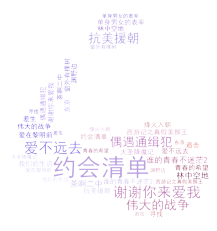

In [39]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/muscle-1085672_1280.png"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'
ls = df_focus_narrowed['片名'].to_list() + ls_ptitles 
# highlights
print(ls)

mask = np.array(Image.open(path_image)) # 定义词频背景
wc = wordcloud.WordCloud(
    font_path=path_font,
    mask=mask, # set back ground mask image
    max_words=44,
    max_font_size=144,
    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    repeat=True,
)
wc.generate(','.join(ls))

image_colors = wordcloud.ImageColorGenerator(mask)
wc.recolor(color_func=image_colors)
plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

wc.to_file(path_img + '/img_title_' + issue_name + '.png')

##[2.5] 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

In [40]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
S0 +=  '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
S0 += '的电影备案公示发布，其中'
S0 += '最遥远的是{}的《{}》，'.format(df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, 
                                                 '备案立项号'], df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
S0 += '慷田AI聚焦关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'
print(S0)

2021年6月4日，4月的电影备案公示发布，其中最遥远的是影重备字〔2019〕第009号的《英雄若兰》，最近期的是影剧备字〔2021〕第1723号的《波涛汹涌》，慷田AI聚焦关注的项目有中国电影的《伟大的战争·抗美援朝》、儒意的《爱不远去》、光线的《约会清单》、《谢谢你来爱我》、《谁的青春不迷茫2》、《茶啊二中》、华策的《渊野边》、思美的《林中空地》、慈文的《偶遇通缉犯》以及横店的《西游记之真假美猴王》。


##[2.6] 指向电影剧官网


In [41]:
#####
T6 = '\n\n'
T6 += '\t慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
T6 += '电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址 '
T6 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(T6)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


#[3] Output Word Document

## 3.1 Install and Load Libraries

In [42]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

     |████████████████████████████████| 5.6MB 8.8MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-cp37-none-any.whl size=184508 sha256=f4343b43b04f06aee9f132cd5ef67c9102575320549fc2cf3a7860dab002bd2c
  Stored in directory: /root/.cache/pip/wheels/a6/90/f1/a7cb70b38633ae04e7fb963b1c70f63fd6fc01c075b8230adc
Successfully built python-docx


## 3.2 Output Docx


In [47]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)
doc.add_paragraph(T3)

doc.add_picture(path_img + '/img_title_' + issue_name + '.png', width =Inches(3))


table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(T6)

doc.save(path_doc + '/overview_' + issue_name + '.docx' )
